In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt      
import pandas as pd
from scipy import special                 
import array
import scipy as sp
import scipy.interpolate
import re
import pickle as pickle
from matplotlib.pyplot import figure


In [2]:
with open('color_data0_cul_integral.pkl', 'rb') as f:
    colors = pickle.load(f)
with open('color_data1_cul_integral.pkl', 'rb') as f:
    colors_1 = pickle.load(f)

In [3]:
colors

[[array([array([0.00000000e+00, 1.58754863e+16, 3.51276633e+16, 5.13598418e+16,
                2.04866804e+18, 5.35759166e+18, 9.33246217e+18])               ,
         list([2.005363879937967, 12.166111410859045, 25.194943977006197])],
        dtype=object),
  1],
 [array([array([0.00000000e+00, 1.50725347e+16, 3.16179342e+16, 4.74190131e+16,
                7.10943839e+16, 8.36902439e+16, 1.00176999e+17, 1.56594640e+17]),
         list([0.13774838491580965, 39.990552201052964, 24.200362598824405])],
        dtype=object),
  3],
 [array([array([0.00000000e+00, 1.01402336e+16, 1.72389788e+16, 2.20239422e+16,
                4.16823922e+16, 1.61106019e+17, 3.22907666e+17, 5.18004678e+17,
                7.15458044e+17, 7.54327102e+17, 7.84246048e+17, 8.23115106e+17]),
         list([27.40319811581587, 27.546867730618853, 24.59833160933951])],
        dtype=object),
  1],
 [array([array([0.00000000e+00, 1.67183055e+16, 3.99534505e+16]),
         list([28.796820774354728, 26.910831985569

In [7]:
lymans = []
for i in colors:
    lymans.append(i)
for i in colors_1:
    lymans.append(i)

In [8]:
need = []
for i in lymans:
    if (np.log10(i[0][0][-1])>20 and i[1] > 1):
        need.append ([i[0][1],i[1]])
    

In [9]:
len(need)

46

In [11]:
import scipy.interpolate
from scipy import integrate
def unPackRawFile(raw_path):
    """


    
    - unpacks the .raw file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]
    gas_density = y[:,4]
    gas_metallicity = y[:,5]
   
    return distance, pec_vel, temp, HI_density, gas_density, gas_metallicity

def getPos(path_LOS,linenumber=8):
    """
    the start position of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr

def getDir(path_LOS,linenumber=8):
    """
    the direction of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x.split(', ')[1]).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr


def convertSphereToCart(theta, phi):
    "converts a unit vector in spherical to cartesian, needed for getGalaxies"
    return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

def calculate_gamma(temperature,density,xHI,scale):
    '''Gamma = R(T)*ne/xHI, R(T) = 4.3e-13 * (T/1e4K)^{-0.7), ne = 0.82*nb.
    '''
    omega_b = 0.0479; h = 0.6814
    mean_nb = 1.123e-5/scale**3*omega_b*h**2
    nb = np.multiply(density ,mean_nb); ne = 0.82*nb
    R_T = 4.3e-13 * (np.divide(temperature,1e4))**(-0.7)
    gamma = R_T * ne / xHI
    
def lyman_identification(limit):
    """
    function for identifying lls using neutral fraction as filter
    """
    neutral_fraction_limit = limit
    
    neutral_fraction = []
    real_lyman = []
    gamma = []
    HI = []
    gas_den = []
    which = []
    for z in range(1000):
        raw_path = 'los.00' + '{0:03}'.format(z) +'.raw'
        distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
        #changing the distance from chimp to cmeters
        distance_cm = distance *0.1452*3.086e24 /0.68
        position = getPos(raw_path)
        direction = convertSphereToCart(getDir(raw_path)[0],getDir(raw_path)[1])
        for k in range(len(distance) -2):
            if(HI_density[k]/gas_density[k]<neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]>neutral_fraction_limit):
                left_bases = k+1
                peak_fraction = HI_density[k]/gas_density[k]
                peak_HI = HI_density[k]
                peak_distance = distance[k]
                peak_gas = gas_density[k]
                if( k+1 <len(distance)):
                    while(not(HI_density[k]/gas_density[k]>neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]<neutral_fraction_limit) and k <len(distance)-2):
                        right_bases = k +1
                        if(k<len(distance)-1):
                            k+=1
                        if(HI_density[k]/gas_density[k]>peak_fraction):
                            peak_fraction = HI_density[k]/gas_density[k]
                            peak_HI = HI_density[k]
                            peak_distance = distance[k]
                            peak_gas = gas_density[k]
                            peak_gamma = calculate_gamma(temp[k],gas_density[k],peak_fraction,0.1452)
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    real_distance = [(position[0]/256*40+peak_distance*direction[0])%40, (position[1]/256*40+peak_distance*direction[1])%40,(position[2]/256*40+peak_distance*direction[2])%40]
                    distance_graph = []
                    HI_graph = [ ]
                    distance_real = []
                    for i in range(len(distance)):
                        if(distance[left_bases]<=distance[i]<= distance[right_bases]):
                            distance_graph.append(distance_cm[i])
                            HI_graph.append(HI_density[i])
                            distance_real.append(distance[i])
                    y_int = integrate.cumtrapz(HI_graph,distance_graph,initial = 0)
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    for i in need:
                        if(real_distance == i[0]):
                            real_lyman.append([y_int[-1],real_distance])
                            neutral_fraction.append(peak_fraction)
                            HI.append(peak_HI)
                            gamma.append(peak_gamma)
                            gas_den.append(peak_gas)
                            which.append([z,distance[left_bases], distance[right_bases], peak_distance,i[1]])
    return real_lyman,neutral_fraction,gamma,HI,gas_den,which 

In [12]:
real_lyman,neutral_fraction,gamma,HI,gas_den,which = lyman_identification(1e-3)

In [20]:
with open('cul_integral.pkl', 'rb') as f:
    lymans = pickle.load(f)

In [21]:
lymans

[[array([0.00000000e+00, 1.58754863e+16, 3.51276633e+16, 5.13598418e+16,
         2.04866804e+18, 5.35759166e+18, 9.33246217e+18]),
  [2.005363879937967, 12.166111410859045, 25.194943977006197]],
 [array([0.00000000e+00, 1.50725347e+16, 3.16179342e+16, 4.74190131e+16,
         7.10943839e+16, 8.36902439e+16, 1.00176999e+17, 1.56594640e+17]),
  [0.13774838491580965, 39.990552201052964, 24.200362598824405]],
 [array([0.00000000e+00, 1.01402336e+16, 1.72389788e+16, 2.20239422e+16,
         4.16823922e+16, 1.61106019e+17, 3.22907666e+17, 5.18004678e+17,
         7.15458044e+17, 7.54327102e+17, 7.84246048e+17, 8.23115106e+17]),
  [27.40319811581587, 27.546867730618853, 24.59833160933951]],
 [array([0.00000000e+00, 1.67183055e+16, 3.99534505e+16]),
  [28.796820774354728, 26.910831985569263, 26.66319852067454]],
 [array([0.00000000e+00, 9.51981210e+15, 1.11698559e+16, 1.92603932e+16]),
  [36.85225536929896, 23.234410457187007, 38.59856728754232]],
 [array([0.00000000e+00, 1.19657716e+16, 2.15

In [22]:
real_lyman

[[1.837306995629986e+20,
  [20.74677583333019, 8.755046260984862, 27.245837300573708]],
 [3.9912514481483376e+20,
  [22.00261419161785, 33.559709349389664, 6.303961325658712]],
 [4.873613509340334e+20,
  [37.970602262771095, 20.252931377175972, 12.819503128729497]],
 [1.4266097175654916e+20,
  [1.8508680028847593, 11.582215171432331, 30.800059721895664]],
 [1.75035042028627e+20,
  [15.342053442494738, 5.703248315695404, 32.15319787153893]],
 [4.4078658415369526e+20,
  [39.55540976260013, 37.53633115192562, 16.806717147560988]],
 [1.0892628456007962e+20,
  [39.97758133327301, 32.22782514054673, 26.184213770817173]],
 [5.887363845760498e+20,
  [10.836535807700479, 15.019542953442283, 32.56348944497806]],
 [1.0623277824495849e+20,
  [30.79711287525872, 11.404951152253496, 10.867994014881528]],
 [2.188422884577254e+20,
  [35.243947161738966, 9.416839626590644, 29.07481021734369]],
 [1.5198531341121683e+20,
  [37.32753997263251, 10.999575894931134, 30.43097437926096]],
 [1.0220484049974375e

In [10]:
old = []
for i in real_lyman:
        old.append(i[0])

In [11]:
plt.scatter(old,new)

[1.6339083883542423e+20,
 3.96248496358605e+20,
 4.8134378564349565e+20,
 1.424789569073179e+20,
 1.746006048859376e+20,
 4.175938446647647e+20,
 6.632185630458888e+19,
 2.859544216600264e+20,
 1.0290961632369258e+20,
 2.188422884577254e+20,
 1.5131198360894364e+20,
 8.08378730996261e+19,
 1.57202376694559e+20,
 2.4103738188398022e+20,
 3.9368319473339656e+20,
 1.4376980476677626e+20,
 1.6441770116204115e+20,
 1.4797427088274578e+20,
 1.275399517260567e+20,
 2.0704405914111024e+20,
 1.4044936672480579e+20,
 2.435089760873015e+20,
 1.5947191167505354e+20,
 1.1209140540437666e+20,
 1.4167590547178965e+20,
 1.529950632479738e+20,
 1.1722336392079286e+20,
 1.0643945058813379e+20,
 2.2717017785926864e+20,
 1.0776636337207792e+20,
 1.7720068700649665e+20,
 1.3130986047008347e+20,
 1.554460905455031e+20,
 1.8228842244632684e+20,
 2.6922456145650955e+20,
 3.91269402427697e+20,
 3.0085603083442926e+20,
 1.365128048949999e+20,
 2.489097812898361e+20,
 1.89731867876675e+20,
 1.6381603207418708e+2

In [15]:
len(which)

46

In [52]:
HI

[0.02555,
 0.0476,
 0.04951,
 0.0209,
 0.02062,
 0.03311,
 0.01351,
 0.02115,
 0.01734,
 0.02639,
 0.02426,
 0.005477,
 0.02649,
 0.03404,
 0.07201,
 0.02861,
 0.02616,
 0.0206,
 0.01596,
 0.0246,
 0.02141,
 0.0229,
 0.02686,
 0.01165,
 0.02148,
 0.03016,
 0.009709,
 0.01563,
 0.05948,
 0.02155,
 0.008429,
 0.02135,
 0.02461,
 0.04421,
 0.06629,
 0.02946,
 0.02463,
 0.01782,
 0.01898,
 0.02037,
 0.02279,
 0.03644,
 0.02189,
 0.05457,
 0.02492,
 0.03083]

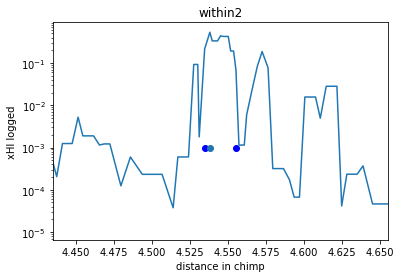

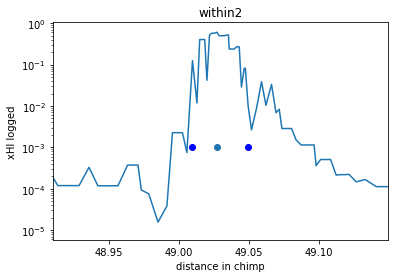

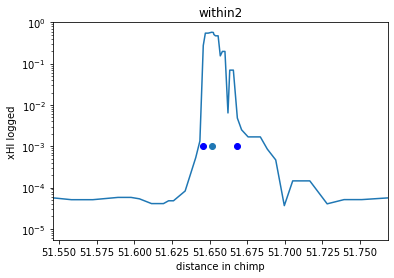

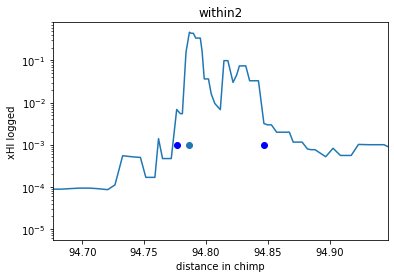

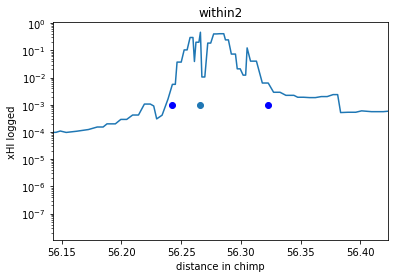

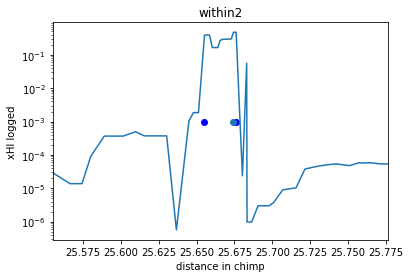

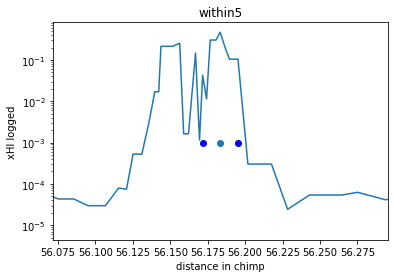

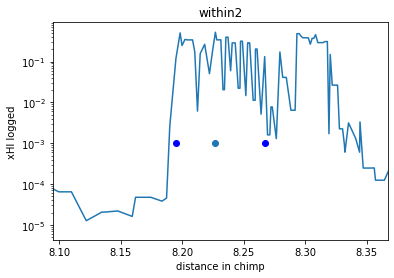

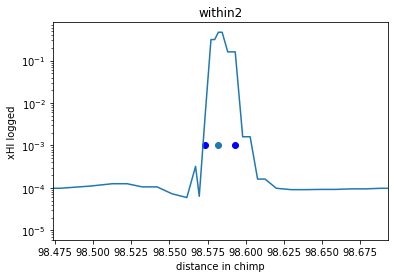

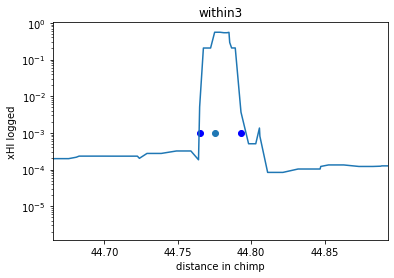

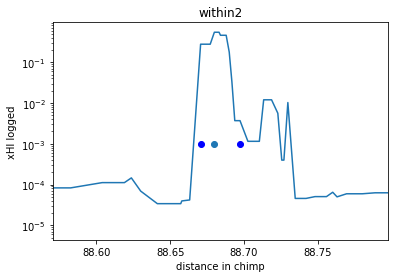

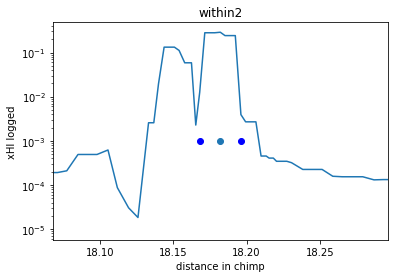

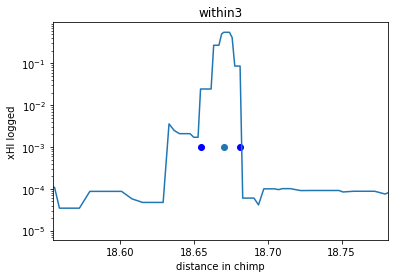

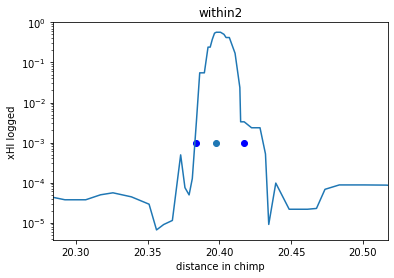

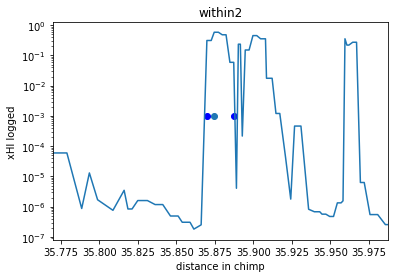

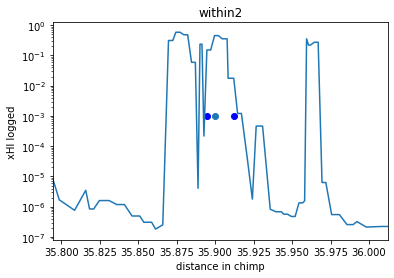

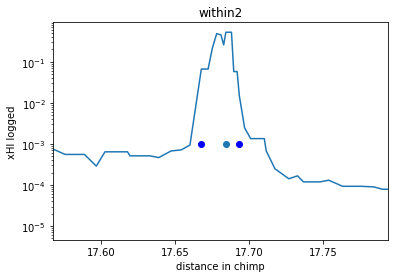

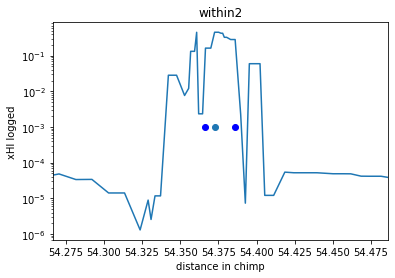

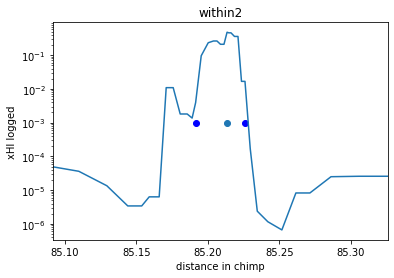

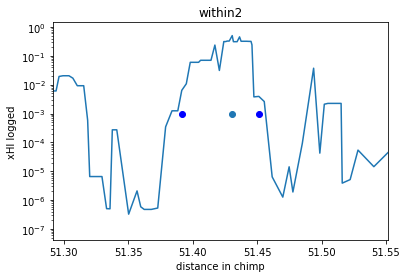

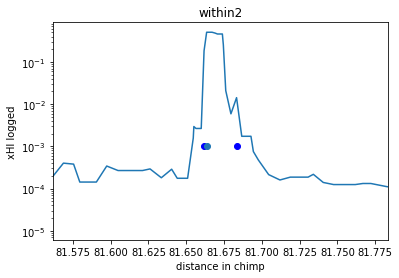

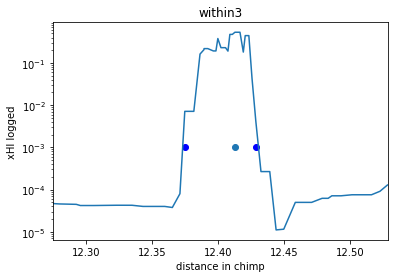

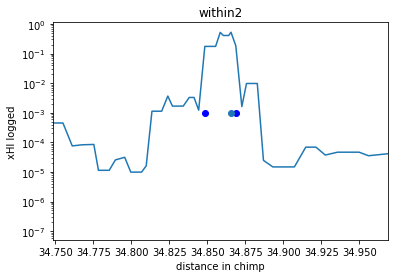

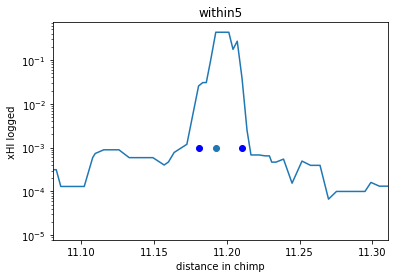

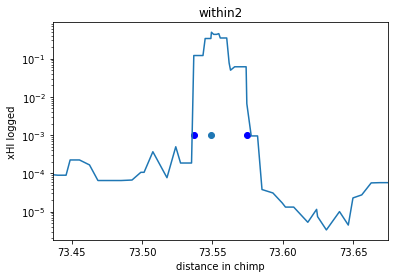

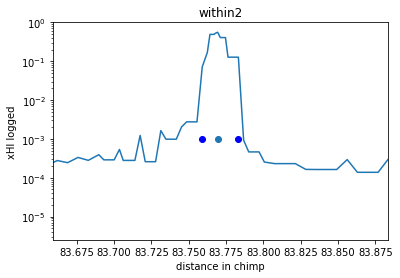

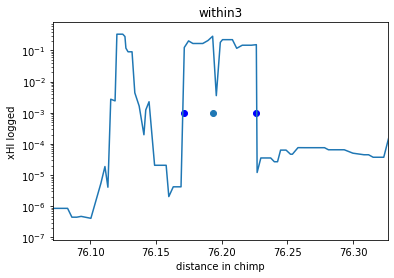

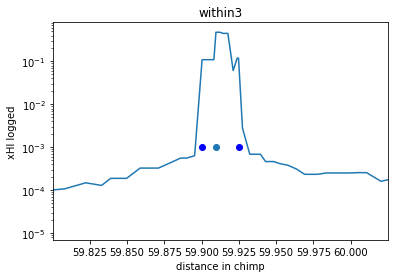

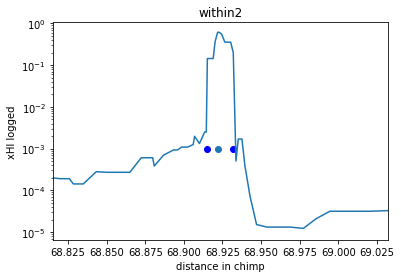

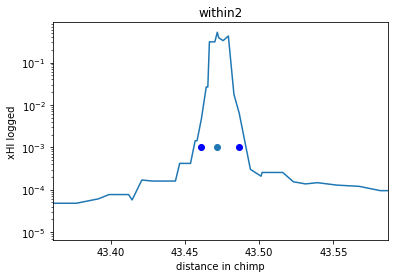

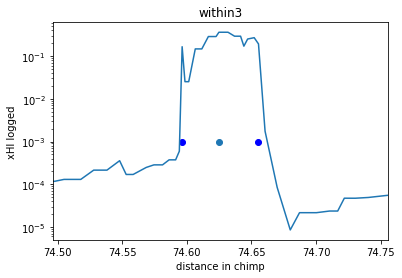

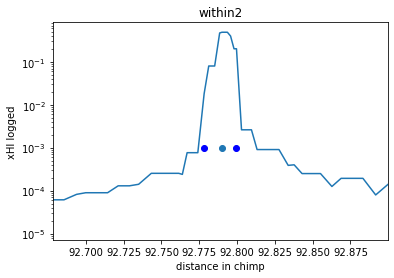

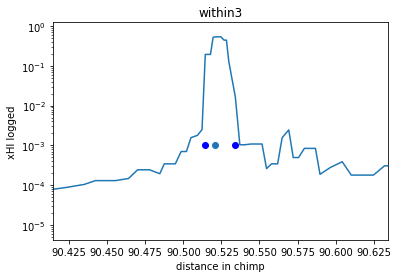

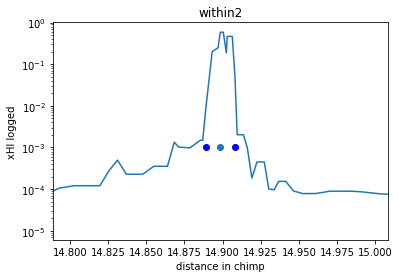

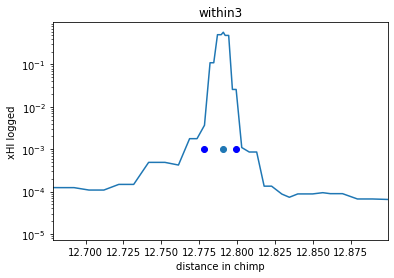

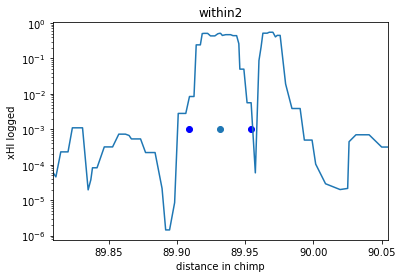

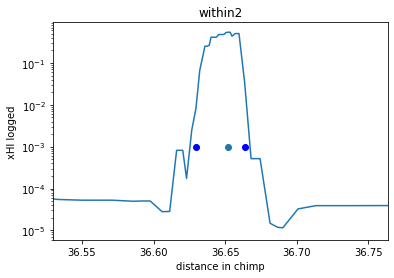

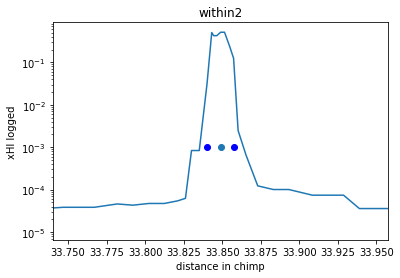

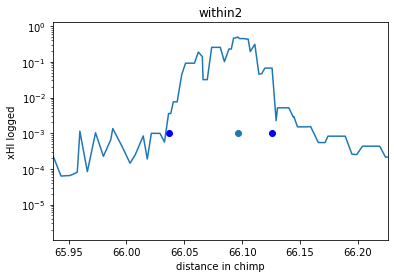

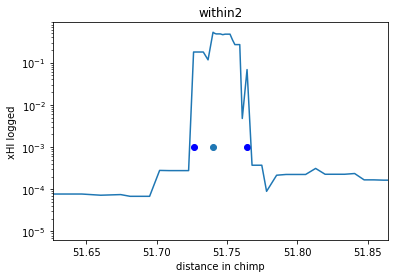

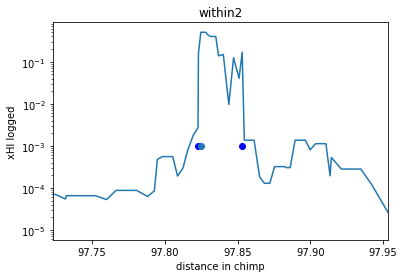

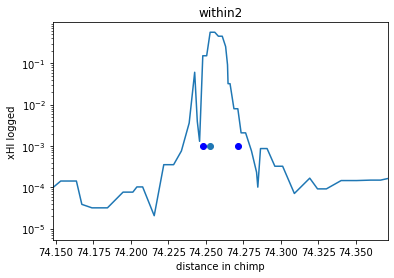

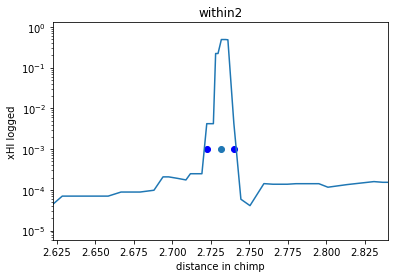

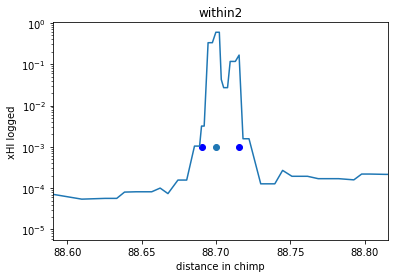

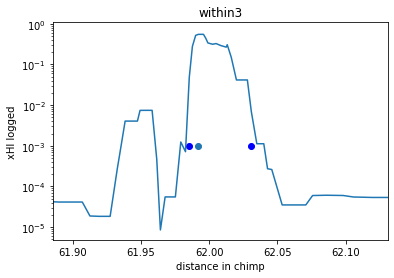

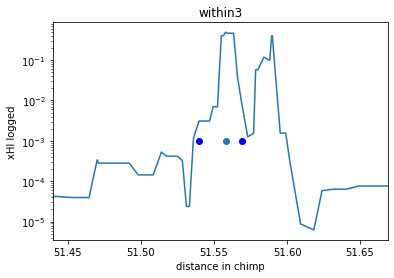

In [16]:
count = 0
for i in which:
    count +=1 
    raw_path = 'los.00' + '{0:03}'.format(i[0]) +'.raw'
    distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
    plt.plot(distance,HI_density/gas_density)
    plt.xlabel("distance in chimp")
    plt.ylabel("xHI logged")
    plt.xlim(i[1] -0.1, i[2] +0.1)
    plt.scatter(i[1],0.001,c="blue")
    plt.scatter(i[2],0.001,c="blue")
    plt.scatter(i[3],0.001)
    plt.yscale("log")
    plt.title("within"+str(i[4]))
    plt.savefig("xHI_log"+str(count) + ".png")
    plt.show()

In [ ]:
distance_cm = distance *0.1452*3.086e24 /0.68

In [ ]:
from scipy import integrate
import matplotlib.pyplot as plt
distance_graph = []
HI_graph = [ ]
distance_real = []
for i in range(len(distance)):
    if(16.1705<=distance[i]<= 16.28787):
        distance_graph.append(distance_cm[i])
        HI_graph.append(HI_density[i])
        distance_real.append(distance[i])
y_int = integrate.cumtrapz(HI_graph,distance_graph,initial = 0)

In [ ]:
y_int

array([0.00000000e+00, 1.04458352e+14, 1.80959241e+14, 2.57427839e+14,
       2.96021708e+14, 3.10804039e+14, 3.78073460e+14, 4.70771703e+14,
       5.18400671e+14])

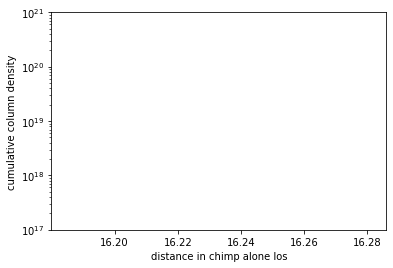

In [ ]:
plt.plot(distance_real, y_int, 'ro')
plt.yscale("log")
plt.ylabel("cumulative column density")
plt.xlabel("distance in chimp alone los")
plt.ylim(1e17,1e21)
plt.show()

In [ ]:
raw_path = 'los.00' + '{0:03}'.format(269) +'.raw'
distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
#changing the distance from chimp to cmeters
distance_cm = distance *0.1452*3.086e24 /0.68
position = getPos(raw_path)
direction = convertSphereToCart(getDir(raw_path)[0],getDir(raw_path)[1])

In [ ]:
direction

array([-0.68539675,  0.01906762, -0.72792013])